Cavity Flow Simulation

https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/14_Step_11.ipynb

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

Persamaan tekanan Poisson yang tertulis di atas bisa jadi sulit untuk ditulis tanpa kesalahan ketik. Fungsi build_up_b di bawah ini merepresentasikan isi dari kurung siku, sehingga keseluruhan PPE sedikit lebih mudah diatur.

In [3]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

Fungsi pressure_poisson juga didefinisikan untuk membantu memisahkan putaran perhitungan yang berbeda. Perhatikan kehadiran variabel waktu semu nit. Sub-iterasi dalam perhitungan Poisson ini membantu memastikan bidang bebas divergensi.

In [4]:
def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

Akhirnya, sisa persamaan aliran rongga dibungkus di dalam fungsi cavity_flow, yang memungkinkan kita untuk dengan mudah memplot hasil dari pemecah aliran rongga untuk jangka waktu yang berbeda.

In [5]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

Mari kita mulai dengan nt = 100 dan lihat apa yang diberikan oleh solver kepada kita:

In [6]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 100
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

Text(0, 0.5, 'Y')

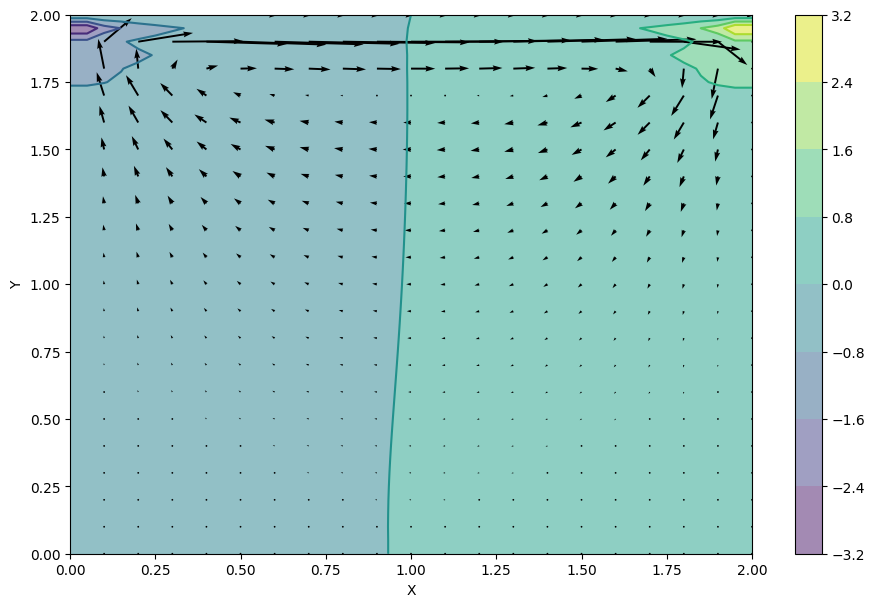

In [7]:
fig = pyplot.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# plotting the pressure field outlines
pyplot.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pyplot.xlabel('X')
pyplot.ylabel('Y')

Anda bisa melihat bahwa dua zona tekanan yang berbeda sedang terbentuk dan pola spiral yang diharapkan dari aliran rongga yang digerakkan oleh tutup mulai terbentuk. Bereksperimenlah dengan nilai nt yang berbeda untuk melihat berapa lama waktu yang dibutuhkan sistem untuk stabil.

In [8]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 700
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

Text(0, 0.5, 'Y')

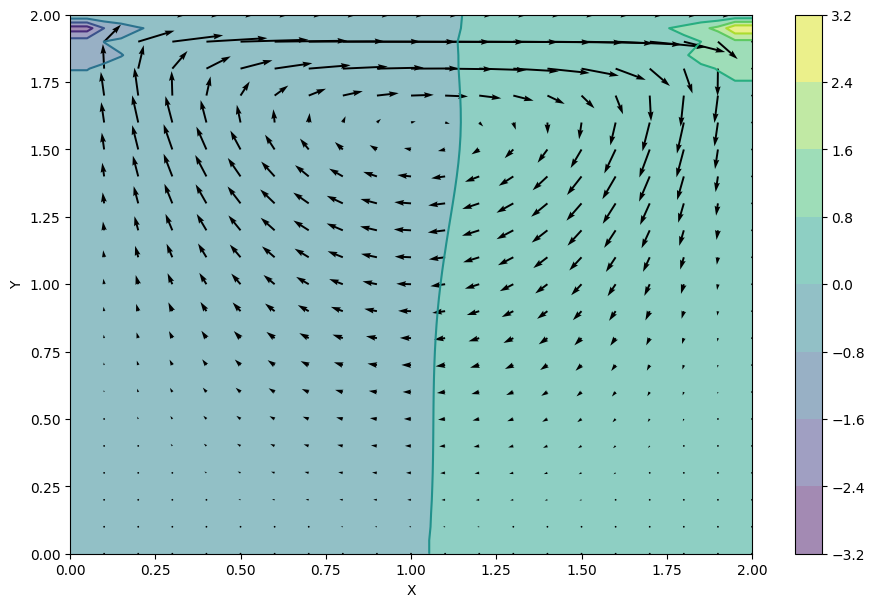

In [9]:
fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y')

Plot quiver menunjukkan besarnya kecepatan pada titik-titik diskrit dalam mesh grid yang kita buat. (Kita sebenarnya hanya menunjukkan setengah dari titik-titik tersebut karena jika tidak, maka akan sedikit berantakan. Sintaks X[::2, ::2] di atas adalah cara yang mudah untuk meminta setiap titik lainnya).

Cara lain untuk memvisualisasikan aliran dalam rongga adalah dengan menggunakan streamplot:

Text(0, 0.5, 'Y')

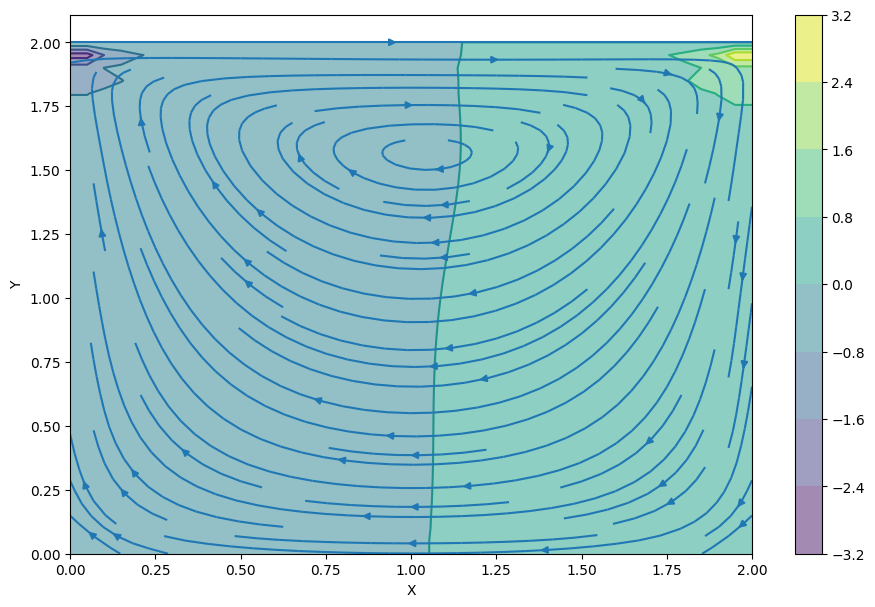

In [10]:
fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y')